In [1]:
from __future__ import absolute_import

import numpy as np
import sys
sys.path.append('datasets')

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.constraints import maxnorm
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

import codeforces
from gcnn import GCNN

batch_size = 64
max_len = 500 
window_size = 3
top_words = 500 # top 2k
embed_dim = 32
gcnn_size = 100
epochs = 20
dropout = 0.2

# fix random seed for reproducibility
np.random.seed(7)
# load the dataset but only keep the top n words, zero the rest
print('Loading data...')
(x_train, y_train), (x_test, y_test) = codeforces.load_data(num_words=top_words)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences') 

# truncate and pad input sequences
x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

print('Build model...')
model = Sequential()
model.add(Embedding(top_words, embed_dim, input_length=max_len))
model.add(Dropout(dropout)) 
model.add(GCNN(gcnn_size, window_size=window_size, name='gcnn1'))
model.add(GCNN(gcnn_size, window_size=window_size, name='gcnn2'))
model.add(GCNN(gcnn_size, window_size=window_size, name='gcnn3'))
model.add(GCNN(gcnn_size, window_size=window_size, name='gcnn4'))
model.add(Flatten())
model.add(Dropout(dropout)) 
model.add(Dense(100, activation='relu', kernel_constraint=maxnorm(3.)))
model.add(Dropout(dropout))          
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test))

Using TensorFlow backend.


Loading data...
(11586, 'train sequences')
(11586, 'test sequences')
('x_train shape:', (11586, 500))
('x_test shape:', (11586, 500))
Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 32)           16000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 500, 32)           0         
_________________________________________________________________
gcnn1 (GCNN)                 (None, 500, 100)          19400     
_________________________________________________________________
gcnn2 (GCNN)                 (None, 500, 100)          60200     
_________________________________________________________________
gcnn3 (GCNN)                 (None, 500, 100)          60200     
_________________________________________________________________
gcnn4 (GCNN)                 (None, 500, 100)          6020

In [6]:
#评估模型好坏
#precision = TP / (TP + FP)
#recall = TP / (TP + FN)
#accuracy = (TP + TN) / (TP + FP + TN + FN)
#F1 Score = 2*P*R/(P+R)，其中P和R分别为 precision 和 recall
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
y_preds = np.round(model.predict(x_test))
result = precision_recall_fscore_support(y_test, y_preds, average='binary')
print(result)

(0.70600080547724531, 0.74216765453005928, 0.72363261093911257, None)


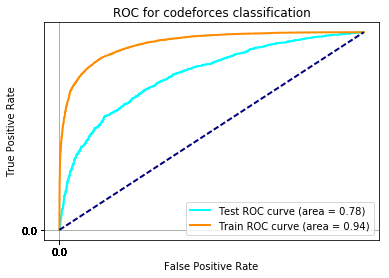

In [5]:
#ROC曲线和AUC
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr={}
tpr={}
roc_auc={}

y_score1 = model.predict(x_test)
y_score2 = model.predict(x_train)

fpr['test'], tpr['test'], _ = roc_curve(y_test, y_score1)
roc_auc['test'] = auc(fpr['test'], tpr['test'])
fpr['train'], tpr['train'], _ = roc_curve(y_train, y_score2)
roc_auc['train'] = auc(fpr['train'], tpr['train'])
    
plt.figure()
lw = 2
plt.plot(fpr['test'], tpr['test'], color='aqua',
         lw=lw, label='Test ROC curve (area = %0.2f)' % roc_auc['test'])
plt.plot(fpr['train'], tpr['train'], color='darkorange',
         lw=lw, label='Train ROC curve (area = %0.2f)' % roc_auc['train'])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

tick_nb = 20
ticks = [x/tick_nb for x in range(1, tick_nb)]
labels = ['%.1f'%tick if tick*10%1==0 else '' for tick in ticks]
plt.xticks(ticks, labels)
plt.yticks(ticks, labels)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for codeforces classification')
plt.legend(loc="lower right")
plt.grid()
plt.show()